In [1]:
from IPython.display import HTML

# Quantum Hot Dog, Not Hot Dog Part 1

## Question: How well can current quantum computers handle highly dimensional data?


## Background
If you have watched Silicon Valley, you would have come across the SeeFood fracas which made Jian Yang a 'very rich man'. If you haven't essentially, the SeeFood app classifies hot dogs and not hot dogs. For this project, we want to adapt this computer vision algorithm to quantum computers to classify hot dogs and not hot dogs using IBMQ.  

## Overview of Current Direction
To achieve this goal practically, we need to find a way to encode highly dimensional image data to the limited qubit registers available. Subsequently, we need to find an appropriate quantum machine learning algorithm and training algorithm that can be feasibly trained given the time constraints. The final output is essentially a binary classifier. The system will likely involve a combination of quantum and classical approaches.

## Video Context


In [2]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/FNyi3nAuLb0" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

/Users/jseam/miniconda3/envs/quantum/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Load Libraries

In [3]:
%matplotlib inline

# import relevant libraries
import secret
import os
import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from qiskit import IBMQ
# standard-ish Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ

# about transpiling, compiling, and executing
from qiskit.compiler import transpile

# For graphs
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Aer noise models
from qiskit.providers.aer import noise

# Save account if you haven't already done so
IBMQ.save_account(secret.TOKEN)

/Users/jseam/miniconda3/envs/quantum/lib/python3.7/site-packages/qiskit/providers/ibmq/credentials/configrc.py:130: UserWarning: Credentials already present. Set overwrite=True to overwrite.
  warnings.warn('Credentials already present. '


# Sanity checks to see if we are properly connected

In [4]:
# Check if IBMQ is working
IBMQ.load_account()
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]

In [5]:
# Get provider and get backends
provider = IBMQ.get_provider(hub='ibm-q')

print('='*81)
print("Simulators")
print('='*81)
pprint.pprint(provider.backends(simulator=True, operational=True))
print()

print('='*81)
print("Real quantum computers")
print('='*81)
pprint.pprint(provider.backends(simulator=False, operational=True))
print()

Simulators
[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>]

Real quantum computers
[<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>]



# Feasibility And Cursory Study With MNIST
We first study the feasibility of this with MNIST dataset. We will classify 1 and 0 digits for a start.

## Load Data and Sanity Checks

In [6]:
# load data
import tensorflow_datasets as tfds
ds_train, ds_test = tfds.load(name="mnist", split=["train", "test"])

/Users/jseam/miniconda3/envs/quantum/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jseam/miniconda3/envs/quantum/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jseam/miniconda3/envs/quantum/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jseam/miniconda3/envs/quantum/lib


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [7]:
train_0 = []
train_1 = []
train_label = []

test_0 = []
test_1 = []
test_label = []

for example in tfds.as_numpy(ds_train):
    numpy_image, numpy_label = example["image"], example["label"]
    if numpy_label == 0:
        train_0.append(numpy_image.reshape((784)))
        train_label.append(numpy_label)
    
    elif numpy_label == 1:
        train_1.append(numpy_image.reshape((784)))
        train_label.append(numpy_label)

        
    else:
        continue

for example in tfds.as_numpy(ds_test):
    numpy_image, numpy_label = example["image"], example["label"]
    if numpy_label == 0:
        test_0.append(numpy_image.reshape((784)))
        test_label.append(numpy_label)
    
    elif numpy_label == 1:
        test_1.append(numpy_image.reshape((784)))
        test_label.append(numpy_label)

    else:
        continue

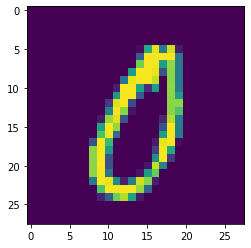

In [8]:
# Sanity Check
pixels = train_0[0]
pixels = pixels.reshape((28,28))
plt.imshow(pixels)

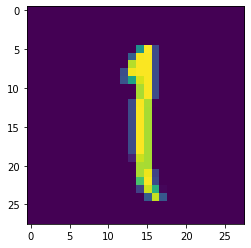

In [9]:
pixels = train_1[0]
pixels = pixels.reshape((28,28))
plt.imshow(pixels)

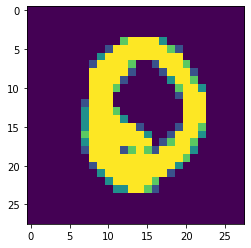

In [10]:
pixels = test_0[0]
pixels = pixels.reshape((28,28))
plt.imshow(pixels)

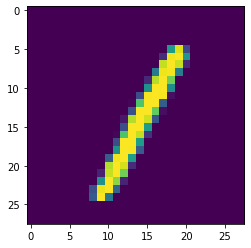

In [11]:
pixels = test_1[0]
pixels = pixels.reshape((28,28))
plt.imshow(pixels)

## Dimensionality Reduction
Try PCA + TSNE

### Apply PCA

(12665, 784)


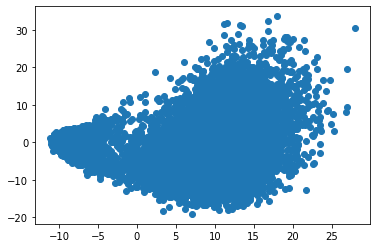

In [12]:
train_all = np.array(train_0 + train_1)
test_all = np.array(test_0 + test_1)

print(train_all.shape)

# Scale images
scaler = StandardScaler()
scaler.fit(train_all)
train_all = scaler.transform(train_all)
test_all = scaler.transform(test_all)

# Apply pca
pca = PCA(n_components=50)
pca.fit(train_all)
train_all = pca.transform(train_all)
test_all = pca.transform(test_all)

plt.scatter(
    train_all[:, 0], train_all[:, 1], cmap=plt.get_cmap('Spectral'))


### Apply T SNE
This is quite costly. We'll avoid using it for the QSVM. It looks like T SNE applied on a raw dataset doesn't really separate information that well.

In [17]:
train_tsne = TSNE(n_components=2, perplexity=5).fit_transform(train_all)

[ 88.1336    23.28286   72.23721  ... -39.59728   -6.562564 -61.57312 ]
[ 39.23274   -54.114407  -17.357641  ...  11.168255   47.172367
  -3.1950028]


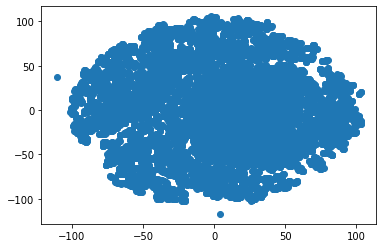

In [22]:
# x, y = np.hsplit(train_tsne, 2)
# x = x.reshape((12665))
# y = y.reshape((12665))
# print(x)
# print(y)
# plt.scatter(x, y, cmap=plt.get_cmap('Spectral'))
# vectors = train_tsne[np.array([item for item in train_label])]

print(train_tsne[:, 0])
print(train_tsne[:, 1])
    
fig, ax = plt.subplots()

# print(train_label)
# for i in len(train_label):
#     if i == 100:
#         break
#     else:
#         ax.scatter(x, y, c=color, s=scale, label=color,
#                alpha=0.3, edgecolors='none')

plt.scatter(
    train_tsne[:, 0], train_tsne[:, 1], cmap=plt.get_cmap('Spectral'))



# Quantum Circuit For Classification

## Quantum SVM Study
Due to time taken to run the training we have to use a very small subset of the dataset. We are losing alot of information. We'll be very happy if this can perform better than random. The dataset is small so this can be just luck, but it's indicative of the general challenges the current Quantum Machine Learning approaches face without availability of QRAM.

We have to simulate this on a macbook instead of using the actual quantum computer because we will submit many jobs on the ibm server and this will take a lot time and also starve other users of server time.

In [31]:
train_0_new = np.array(train_0)
train_1_new = np.array(train_1)

test_0_new = np.array(test_0)
test_1_new = np.array(test_1)

# Scale images
scaler = StandardScaler()
scaler.fit(train_0_new)
train_0_new = scaler.transform(train_0_new)
train_1_new = scaler.transform(train_1_new)
test_0_new = scaler.transform(test_0_new)
test_1_new = scaler.transform(test_1_new)

In [32]:
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import run_algorithm, QuantumInstance

### Experiment 
#### Prematurely Stopped at n_components: 4, n_depth: 5
#### Best results considering time, at n_components: 3, n_depth: 3

#### Results (Accuracy)
| n_components/ n_depth       | 2       | 3     | 4    | 5    |
| --------------------------- | ------- | ----- |------|------|
| 2                           | 0.6     | 0.5   | 0.25 |0.55  |
| 3                           |         | 0.65  | 0.45 | 0.4  |
| 4                           |         |       | 0.6  | 0.65 |

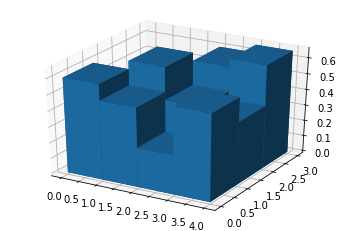

In [67]:
n_2 = [0.6, 0.5, 0.25, 0.55]
n_3 = [0, 0.65, 0.45, 0.4]
n_4 = [0, 0, 0.6, 0.65]
n = [n_2, n_3, n_4]


data_array = np.array(n)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_data, y_data = np.meshgrid( np.arange(data_array.shape[1]),
                              np.arange(data_array.shape[0]) )


x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = data_array.flatten()
ax.bar3d( x_data,
          y_data,
          np.zeros(len(z_data)),
          1, 1, z_data )

plt.show()

In [59]:
all_results = {}

for n_components in range(2, 6):
    n_depth = n_components

    while n_depth < 6:
        pca = PCA(n_components=n_components)
        pca.fit(train_0_new)
        train_0_pca = pca.transform(train_0_new)
        train_1_pca = pca.transform(train_1_new)
        test_0_pca = pca.transform(test_0_new)
        test_1_pca = pca.transform(test_1_new)

        training_dataset_size = 20
        testing_dataset_size = 10
        random_seed = 10598
        shots = 1024


        train_0_final = train_0_pca[:training_dataset_size]
        train_1_final = train_1_pca[:training_dataset_size]

        test_0_final = test_0_pca[:testing_dataset_size]
        test_1_final = test_1_pca[:testing_dataset_size]

        train_dataset = {'0': train_0_final, 
                         '1': train_1_final}

        test_dataset = {'0': test_0_final, 
                        '1': test_1_final}

        class_name = {'0': 0, '1': 1}

        train_datapoints, class_to_label_train = split_dataset_to_data_and_labels(train_dataset, class_name)
        test_datapoints, class_to_label_test = split_dataset_to_data_and_labels(test_dataset, class_name)

#         print(class_to_label_train)
#         print(class_to_label_test)

        # backend = IBMQ.backend('qasm_simulator')             
        backend = Aer.get_backend('qasm_simulator')

        feature_map = SecondOrderExpansion(n_components, depth=n_depth)
        svm = QSVM(feature_map, train_dataset, test_dataset, None)# the data for prediction can be feeded later.
        svm.random_seed = random_seed
        quantum_instance = QuantumInstance(backend, shots=shots)
        result = svm.run(quantum_instance)
        
        print("n_components: {}, n_depth: {}".format(n_components, n_depth))
        print(result['testing_accuracy'])
        all_results[(n_components, n_depth)] = result
        
        n_depth += 1

KeyboardInterrupt: 

# Comparison with Classical SVM
We compare the Quantum SVM with a Classical SVM using the same input data

 | n_components | accuracy |
 | ------------ | -------- |
 | 2            | 1.0      |
 | 3            | 1.0      |
 | 4            | 0.95     |
 | 5            | 1.0      |

In [39]:
from sklearn.svm import SVC

In [42]:
all_results = []

for n_components in range(2, 6):
    training_dataset_size = 20
    testing_dataset_size = 10
    
    pca = PCA(n_components=n_components)
    pca.fit(train_0_new)
    train_0_pca = pca.transform(train_0_new)
    train_1_pca = pca.transform(train_1_new)
    test_0_pca = pca.transform(test_0_new)
    test_1_pca = pca.transform(test_1_new)

    train_0_final = train_0_pca[:training_dataset_size]
    train_1_final = train_1_pca[:training_dataset_size]

    test_0_final = test_0_pca[:testing_dataset_size]
    test_1_final = test_1_pca[:testing_dataset_size]

    train_dataset = {'0': train_0_final, 
                     '1': train_1_final}

    test_dataset = {'0': test_0_final, 
                    '1': test_1_final}

    class_name = {'0': 0, '1': 1}

    train_datapoints, class_to_label_train = split_dataset_to_data_and_labels(train_dataset, class_name)
    test_datapoints, class_to_label_test = split_dataset_to_data_and_labels(test_dataset, class_name)

    clf = SVC()
    clf.fit(train_datapoints, class_to_label_train)
    
    result = clf.score(test_datapoints, class_to_label_test)
    
    print(result)

/Users/jseam/miniconda3/envs/quantum/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/jseam/miniconda3/envs/quantum/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


1.0
1.0
0.95
1.0


/Users/jseam/miniconda3/envs/quantum/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/jseam/miniconda3/envs/quantum/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# Conclusion: No practical reason to use Quantum Machine Learning instead of Classical Machine Learning at the moment (dated: 12 Oct 2019)

## Key Missing Ingredients: More Qubits, and QRAM


Using QSVM on high dimensional data without QRAM at the moment is not very practical at the moment. More qubits is required in order to have more useful results. There's still probably a long way to go to for quantum machine learning approaches to rival classical machine learning approaches. 

# Other Ideas To Look Into
These are other architectures that we wanted to look into but didn't have the time.

# Tree Tensor Network
From [Hierarchical Quantum Classifiers](https://www.nature.com/articles/s41534-018-0116-9)

In [91]:
import numpy as np
qr = QuantumRegister(4, 'qr')
cr = ClassicalRegister(1, 'cr')
circuit = QuantumCircuit(qr, cr)

theta_0 = np.random.rand((4))
theta_1 = np.random.rand((2))


circuit.h(qr)
circuit.ry(theta_0, qr)
circuit.cx(qr[0], qr[1])
circuit.cx(qr[3], qr[2])
circuit.ry(theta_1, qr[1:3])
circuit.cx(qr[1], qr[2])
circuit.measure(qr[2], cr[0])
circuit.draw('mpl_plot')

## [Distance-based classifier with a quantum interference circuit](https://arxiv.org/pdf/1703.10793.pdf)

Click for more info

![image.png](image.png)

# [Quantum classification of the MNIST dataset via Slow Feature Analysis](https://arxiv.org/pdf/1805.08837.pdf)


Simulate QRAM inefficiently classically.